# A Data-Driven Approach to Understanding Cybersecurity Risks with UNODC Insights

## Introduction and set up

UNODC: https://dataunodc.un.org/dp-crime-corruption-offences
World Bank internet usage: https://data.worldbank.org/indicator/IT.NET.USER.ZS
Secure internet servers: https://data.worldbank.org/indicator/IT.NET.SECR
Secure Internet servers per 1 million people: https://data.worldbank.org/indicator/IT.NET.SECR.P6

### Package loading

In [ ]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from google.colab import drive

## Data processing

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Initial loading of data

In [ ]:
# Define file paths
file_path_un = "/content/drive/MyDrive/data_cts_corruption_and_economic_crime.xlsx"
file_path_wb = "/content/drive/MyDrive/world_bank.xlsx"


xls_un = pd.ExcelFile(file_path_un)
xls_wb = pd.ExcelFile(file_path_wb)

# Check if all sheets got loaded
print('<----Sheets of UNODC dataset---->')
print(xls_un.sheet_names)
print('<----Sheets of World Bank dataset---->')
print(xls_wb.sheet_names)


<----Sheets of UNODC dataset---->
['data_cts_corruption_and_economi']
<----Sheets of World Bank dataset---->
['Internet users (% of population', 'Secure Severs (absolute)', 'Secure servers (per 1 million)']


In [ ]:
df_un = pd.read_excel(xls_un, sheet_name="data_cts_corruption_and_economi")

df_un.head()

,UNODC,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,16/05/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE,Source
2,ARM,Armenia,Asia,Western Asia,Offences,by type of offence,Corruption,Total,Total,2013,Counts,782,CTS
3,AUT,Austria,Europe,Western Europe,Offences,by type of offence,Corruption,Total,Total,2013,Counts,3439,CTS
4,CHE,Switzerland,Europe,Western Europe,Offences,by type of offence,Corruption,Total,Total,2013,Counts,4884,CTS


In [ ]:
# Load different sheets into dataframes
df_internet_users = pd.read_excel(xls_wb, sheet_name="Internet users (% of population")
df_absolute_servers = pd.read_excel(xls_wb, sheet_name="Secure Severs (absolute)")
df_relative_servers = pd.read_excel(xls_wb, sheet_name="Secure servers (per 1 million)")

In [ ]:
# Look at first entries of dfs
print('<----Internet users---->')
print(df_internet_users.head(1))
print('<----Secure servers---->')
print(df_absolute_servers.head(1))
print('<----Secure servers per 1 million---->')
print(df_relative_servers.head(1))

<----Internet users---->
  Country Name Country Code                                    Indicator Name  \
0        Aruba          ABW  Individuals using the Internet (% of population)   

   Indicator Code  1960  1961  1962  1963  1964  1965  ...   2014     2015  \
0  IT.NET.USER.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  83.78  88.6612   

      2016   2017  2018  2019  2020  2021  2022  2023  
0  93.5425  97.17   NaN   NaN   NaN   NaN   NaN   NaN  

[1 rows x 68 columns]
<----Secure servers---->
  Country Name Country Code           Indicator Name Indicator Code  1960  \
0        Aruba          ABW  Secure Internet servers    IT.NET.SECR   NaN   

   1961  1962  1963  1964  1965  ...  2014  2015   2016   2017   2018   2019  \
0   NaN   NaN   NaN   NaN   NaN  ...  59.0  79.0  123.0  103.0  122.0  149.0   

    2020   2021   2022   2023  
0  169.0  177.0  174.0  150.0  

[1 rows x 68 columns]
<----Secure servers per 1 million---->
  Country Name Country Code                          

As seen above the data got loaded into the different data frames, but needs some processing to bring it into a structure and more accessible format that the analysis can build on. Up on first inspection, we need to rename the columns for the UNODC data set right and reindex the rows. Moreover, as we can see above, the World Bank data is in a wrong format, and needs to be melted so that we can merge the datasets later more easily. We'll begin with processing the UNODC later first and then move to the other three datasets.

**UNDOC data**

In [ ]:
# Get right column names and reindex data frame
df_un.columns = df_un.iloc[1]
df_un = df_un[2:].reset_index(drop=True)

In [ ]:
# Rename columns for easier reference
df_un.columns = ["Iso3_code", "Country", "Region", "Subregion", "Indicator",
              "Dimension", "Category", "Sex", "Age", "Year",
              "Unit", "Value", "Source"]

Before moving on with further analysis, we also need to create a subset from our dataset that only contains the relevant categories which we are interested in. Since it is not possible to select which factors are included in the dataset, by default all categories that are contained in the database will be inlcuded.

In [ ]:
# Display all categories that are included
df_un["Category"].unique()

array(['Corruption', 'Corruption: Bribery',
       'Corruption: Other acts of corruption', 'Smuggling of migrants',
       'Burglary', 'Theft', 'Theft: of a motorized vehicle', 'Fraud',
       'Fraud: Cyber-related (Cy)', 'Money laundering',
       'Unlawful access to a computer system',
       'Unlawful interference with a computer system or computer data',
       'Unlawful interception or access of computer data',
       'Acts that cause environmental pollution or degradation',
       'Acts involving the movement of dumping of waste',
       'Trade or possession of protected or prohibited species of faune and flora',
       'Acts that result in the depletion of degradation of natural resources'],
      dtype=object)

In [ ]:
# Specify only relevant categories
cyber_crime_categories = [
    "Unlawful access to a computer system",
    "Unlawful interference with a computer system or computer data",
    "Unlawful interception or access of computer data"
]

# Create subset of dataframe
df_cyber = df_un[df_un["Category"].isin(cyber_crime_categories)].copy()

In [ ]:
# Check if subset is correct
df_cyber["Category"].unique()

array(['Unlawful access to a computer system',
       'Unlawful interference with a computer system or computer data',
       'Unlawful interception or access of computer data'], dtype=object)

In [ ]:
# Print resulting dataframe
df_cyber.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit,Value,Source
9348,ARM,Armenia,Asia,Western Asia,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2014,Counts,0,CTS
9349,BEL,Belgium,Europe,Western Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2014,Counts,2055,CTS
9350,CHE,Switzerland,Europe,Western Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2014,Counts,314,CTS
9351,CZE,Czechia,Europe,Eastern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2014,Counts,669,CTS
9352,DMA,Dominica,Americas,Latin America and the Caribbean,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2014,Counts,0,CTS


In [ ]:
# Step 1: Pivot the data, keeping all the necessary columns as the index
df_cyber = df_cyber.pivot_table(index=["Iso3_code", "Country", "Region", "Subregion", "Indicator","Dimension", "Category", "Sex", "Age", "Year","Source"],
                                            columns='Unit',
                                            values='Value', aggfunc='first').reset_index()

# Step 2: Rename the columns for better clarity
df_cyber.columns = ["Iso3_code", "Country", "Region", "Subregion", "Indicator","Dimension", "Category", "Sex", "Age", "Year","Source","absolute_value", "rate_value"]

# Step 3: View the result
df_cyber.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Source,absolute_value,rate_value
0,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2015,CTS,5,0.173462
1,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2016,CTS,12,0.416513
2,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2017,CTS,9,0.31257
3,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2018,CTS,12,0.417099
4,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2019,CTS,14,0.487146


**World Bank data**

Moving on to the data which we obtained from the
World Bank database, we will need to melt the data, to bring it into the right format so we can merge it with the UNODC data later.

In [ ]:
# View current columns of dataframe
df_absolute_servers.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')

As we have seen above, currently the data is in the wrong format and needs to be reshaped so we can use it for fruther analysis. That is why we will stack the data with one row for each column.

In [ ]:
# Melt the dataframe to long format
df_internet_users_long = df_internet_users.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Internet_Usage"
)

df_absolute_servers_long = df_absolute_servers.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Secure Internet servers"
)

df_relative_servers_long = df_relative_servers.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Secure Internet servers (per 1 million people)"
)

In [ ]:
# Check one dataframe if transformation was successful
df_internet_users_long.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Internet_Usage
0,Aruba,ABW,Individuals using the Internet (% of population),IT.NET.USER.ZS,1960,NaN
1,Africa Eastern and Southern,AFE,Individuals using the Internet (% of population),IT.NET.USER.ZS,1960,NaN
2,Afghanistan,AFG,Individuals using the Internet (% of population),IT.NET.USER.ZS,1960,NaN
3,Africa Western and Central,AFW,Individuals using the Internet (% of population),IT.NET.USER.ZS,1960,NaN
4,Angola,AGO,Individuals using the Internet (% of population),IT.NET.USER.ZS,1960,NaN


As we can see above, the transformation into a long data form was successful. Now each row represents the internet usage rate for a specific country in an specific year, matching the format in the UNODC dataset. We will move on to further processing the data to make it useful for the later data exploration.

In [ ]:
# Convert 'Year' to integer
df_internet_users_long["Year"] = pd.to_numeric(df_internet_users_long["Year"], errors="coerce")
df_absolute_servers_long["Year"] = pd.to_numeric(df_absolute_servers_long["Year"], errors="coerce")
df_relative_servers_long["Year"] = pd.to_numeric(df_relative_servers_long["Year"], errors="coerce")

### Merging the datasets

After some data processing, the four indivdual datasets are now ready to be merge into one dataset, on which we will base the cleaning of the data and the later analysis upon. We will merge the dataset upon two columns which are present in all dataframes, the year and the ISO3 country codes. But before merging the datasets, we need to do some quick processing to make the column names match.

In [ ]:
# Rename column to match
df_internet_users_long.rename(columns={"Country Code": "Iso3_code"}, inplace=True)

df_relative_servers_long.rename(columns={"Country Code": "Iso3_code"}, inplace=True)

df_absolute_servers_long.rename(columns={"Country Code": "Iso3_code"}, inplace=True)

After renaming the columns of the World Bank data, we will create a copy of our initial dataframe, which we will use as a backup and not overwrite the whole dataframe and risk losing it.

In [ ]:
# Start with your cleaned cybercrime dataset as the foundation
df_final = df_cyber.copy()

In [ ]:
# Merge in internet usage
df_final = pd.merge(df_final, df_internet_users_long, on=["Iso3_code", "Year"], how="left")

# Merge in absolute secure server count
df_final = pd.merge(df_final, df_absolute_servers_long, on=["Iso3_code", "Year"], how="left")

# Merge in secure servers per million
df_final = pd.merge(df_final, df_relative_servers_long, on=["Iso3_code", "Year"], how="left")

To check if the merging was successful, we will inspect the final dataframe.

In [ ]:
df_final.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,...,Indicator Code_x,Internet_Usage,Country Name_y,Indicator Name_y,Indicator Code_y,Secure Internet servers,Country Name,Indicator Name,Indicator Code,Secure Internet servers (per 1 million people)
0,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2015,...,IT.NET.USER.ZS,56.9000,Albania,Secure Internet servers,IT.NET.SECR,197.0,Albania,Secure Internet servers (per 1 million people),IT.NET.SECR.P6,68.386085
1,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2016,...,IT.NET.USER.ZS,59.6000,Albania,Secure Internet servers,IT.NET.SECR,416.0,Albania,Secure Internet servers (per 1 million people),IT.NET.SECR.P6,144.640261
2,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2017,...,IT.NET.USER.ZS,62.4000,Albania,Secure Internet servers,IT.NET.SECR,1273.0,Albania,Secure Internet servers (per 1 million people),IT.NET.SECR.P6,443.020376
3,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2018,...,IT.NET.USER.ZS,65.4000,Albania,Secure Internet servers,IT.NET.SECR,1508.0,Albania,Secure Internet servers (per 1 million people),IT.NET.SECR.P6,526.099856
4,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2019,...,IT.NET.USER.ZS,68.5504,Albania,Secure Internet servers,IT.NET.SECR,2190.0,Albania,Secure Internet servers (per 1 million people),IT.NET.SECR.P6,767.292728


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 25 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Iso3_code                                       859 non-null    object 
 1   Country                                         859 non-null    object 
 2   Region                                          859 non-null    object 
 3   Subregion                                       859 non-null    object 
 4   Indicator                                       859 non-null    object 
 5   Dimension                                       859 non-null    object 
 6   Category                                        859 non-null    object 
 7   Sex                                             859 non-null    object 
 8   Age                                             859 non-null    object 
 9   Year                                       

## Data cleaning

The next phase of the data analysis process is to clean the processed data and make it ready for the further EDA steps. After initially inspecting the final dataframe, we can see that we got some duplicate columns, due to the process of merging the different datasets, that we can remove to clean up the dataframe.

In [ ]:
df_final.columns

Index(['Iso3_code', 'Country', 'Region', 'Subregion', 'Indicator', 'Dimension',
       'Category', 'Sex', 'Age', 'Year', 'Source', 'absolute_value',
       'rate_value', 'Country Name_x', 'Indicator Name_x', 'Indicator Code_x',
       'Internet_Usage', 'Country Name_y', 'Indicator Name_y',
       'Indicator Code_y', 'Secure Internet servers', 'Country Name',
       'Indicator Name', 'Indicator Code',
       'Secure Internet servers (per 1 million people)'],
      dtype='object')

In [ ]:
# List of columns to drop
columns_to_drop = ['Country Name_x', 'Indicator Name_x', 'Indicator Code_x','Country Name_y', 'Indicator Name_y', 'Indicator Code_y', 'Country Name', 'Indicator Name', 'Indicator Code']

# Drop the columns
df_final.drop(columns=columns_to_drop, inplace=True)

# Look at data
df_final.head()

,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Source,absolute_value,rate_value,Internet_Usage,Secure Internet servers,Secure Internet servers (per 1 million people)
0,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2015,CTS,5,0.173462,56.9000,197.0,68.386085
1,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2016,CTS,12,0.416513,59.6000,416.0,144.640261
2,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2017,CTS,9,0.31257,62.4000,1273.0,443.020376
3,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2018,CTS,12,0.417099,65.4000,1508.0,526.099856
4,ALB,Albania,Europe,Southern Europe,Offences,by type of offence,Unlawful access to a computer system,Total,Total,2019,CTS,14,0.487146,68.5504,2190.0,767.292728


Upon further inspection, it looks like that the columns Indicator, Dimension, Sex and Age seem to only contain the same amount of information and therefore are also safe to drop. To test this, we will look at the amount of unique values in each column and then conclude which columns we will keep for the further analysis.

In [ ]:
unique_final = pd.DataFrame({
    'Unique Values': df_final.nunique(),
})
print("<---Unique Values in columns--->")
print(unique_final)

<---Unique Values in columns--->
                                                Unique Values
Iso3_code                                                  79
Country                                                    79
Region                                                      4
Subregion                                                  12
Indicator                                                   1
Dimension                                                   1
Category                                                    3
Sex                                                         1
Age                                                         1
Year                                                        8
Source                                                      3
absolute_value                                            403
rate_value                                                720
Internet_Usage                                            345
Secure Internet servers              

As we can see, the columns Indicator, Dimension, Sex and Age indeed only contain one unique value. Thus we can conclude that these columns wont be essential for our analysis. But before we will drop them, we will look at the values in these columsn to be sure that they can be dropped.

In [ ]:
# List columns with only one unique value
single_value_cols = unique_final[unique_final['Unique Values'] == 1].index.tolist()

for col in single_value_cols:
    unique_val = df_final[col].unique()
    print(f"{col}: {unique_val}")

Indicator: ['Offences']
Dimension: ['by type of offence']
Sex: ['Total']
Age: ['Total']


Now we can be certain that this information won't be useful for our analysis and the columns can therefore be dropped.

In [ ]:
df_final_cleaned = df_final.drop(columns=single_value_cols)

df_final_cleaned.head()

,Iso3_code,Country,Region,Subregion,Category,Year,Source,absolute_value,rate_value,Internet_Usage,Secure Internet servers,Secure Internet servers (per 1 million people)
0,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2015,CTS,5,0.173462,56.9000,197.0,68.386085
1,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2016,CTS,12,0.416513,59.6000,416.0,144.640261
2,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2017,CTS,9,0.31257,62.4000,1273.0,443.020376
3,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2018,CTS,12,0.417099,65.4000,1508.0,526.099856
4,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2019,CTS,14,0.487146,68.5504,2190.0,767.292728


### Handling missing values

One essential part of the data cleaning phase, is the handling of missing values in the data. To explore this we will first inspect the data upon missing values.

In [ ]:
missing_final_cleaned = pd.DataFrame({
    'Data Type': df_final_cleaned.dtypes,
    'Missing Values': df_final_cleaned.isnull().sum(),
})
print("<---Short summary of missing values--->")
print(missing_final_cleaned)

<---Short summary of missing values--->
                                               Data Type  Missing Values
Iso3_code                                         object               0
Country                                           object               0
Region                                            object               0
Subregion                                         object               0
Category                                          object               0
Year                                               int64               0
Source                                            object               0
absolute_value                                    object               0
rate_value                                        object               0
Internet_Usage                                   float64              27
Secure Internet servers                          float64              28
Secure Internet servers (per 1 million people)   float64              28


As we can see above, some of our target columns don't have the right data type and need to be converted to be rightfully used in the data exploration.

In [ ]:
# Convert 'absolute_value' and 'rate_value' columns to float
df_final_cleaned['absolute_value'] = pd.to_numeric(df_final_cleaned['absolute_value'], errors='coerce')
df_final_cleaned['rate_value'] = pd.to_numeric(df_final_cleaned['rate_value'], errors='coerce')

# Convert 'Year' column to datetime
df_final_cleaned['Year'] = pd.to_datetime(df_final_cleaned['Year'], format='%Y')

In [ ]:
missing_cols = [
    "Internet_Usage",
    "Secure Internet servers",
    "Secure Internet servers (per 1 million people)"
]

# Filter rows with missing data
missing_data = df_final_cleaned[df_final_cleaned[missing_cols].isnull().any(axis=1)]

# List of  countries
countries_with_missing = missing_data["Country"].unique()

# Show countries
print("Countries with missing data are :")
print(countries_with_missing)

Countries with missing data are :
['United Kingdom (England and Wales)' 'United Kingdom (Scotland)'
 'Kosovo under UNSCR 1244']


In [ ]:
#Count the total number of rows in the DataFrame
total_rows = df_final_cleaned.shape[0]


missing_rows = df_final_cleaned.isnull().any(axis=1).sum()

# Calculate the percentage of rows with missing values
missing_percentage = (missing_rows / total_rows) * 100

# Print the result
print(f"Percentage of rows with missing values: {missing_percentage:.2f}%")

Percentage of rows with missing values: 3.26%


In [ ]:

missing_other_columns = df_final_cleaned.drop(columns=['absolute_value']).isnull().any(axis=1)
sum_missing_other_columns = df_final_cleaned.loc[missing_other_columns, 'absolute_value'].sum()

# Calculate the  sum
total_absolute_value = df_final_cleaned['absolute_value'].sum()

# Calculate the percentage
missing_percentage_absolute_value = (sum_missing_other_columns / total_absolute_value) * 100

print(f"Percentage of the sum of 'absolute_value' for rows with missing values in other columns: {missing_percentage_absolute_value:.2f}%")


Percentage of the sum of 'absolute_value' for rows with missing values in other columns: 2.65%


By exploring the count of missing data for each column and the which of the countries have missing data, we can see that only all the missing data comes from 3 countries and only 3 columns are effected. It also appears that all the missing data is a product of join the World Bank dataset. Just more than 3% of the data rows have missing values, which account for only 2,65% of the absolute number of cyber incidents in the whole dataset.


---

There are various different techniques about dealing with missing values. The most straight forward option would be to just drop the rows. More sophistiated techniques range from filling the missing data with the mean or median of the whole dataset or with the mean or median of a identified subgroup. In addition to this, even more complex techniques like the closest fit of data or k-nearest neighbor which looks for entries similar of the ones that has a missing value and replaces the value with an existing value of the identified entry.

In [ ]:
df_knn = df_final_cleaned[['Internet_Usage', 'Secure Internet servers', 'Secure Internet servers (per 1 million people)']]

# Apply imputation
knn_imputer = KNNImputer(n_neighbors=5)  # Use the top 5 closest countries
df_knn_imputed = knn_imputer.fit_transform(df_knn)

# Replace original data with the imputed values
df_final_cleaned[['Internet_Usage', 'Secure Internet servers', 'Secure Internet servers (per 1 million people)']] = df_knn_imputed

df_final_cleaned.head()

,Iso3_code,Country,Region,Subregion,Category,Year,Source,absolute_value,rate_value,Internet_Usage,Secure Internet servers,Secure Internet servers (per 1 million people)
0,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2015-01-01,CTS,5,0.173462,56.9000,197.0,68.386085
1,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2016-01-01,CTS,12,0.416513,59.6000,416.0,144.640261
2,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2017-01-01,CTS,9,0.312570,62.4000,1273.0,443.020376
3,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2018-01-01,CTS,12,0.417099,65.4000,1508.0,526.099856
4,ALB,Albania,Europe,Southern Europe,Unlawful access to a computer system,2019-01-01,CTS,14,0.487146,68.5504,2190.0,767.292728


## Data exploration

Now that we have finally cleaned the data and we can start with exploring it. We will first start with non-visualizing exploration, looking at some key measures of the data. After that we will move use various forms of visualizatinons to better understand the given data.

### Measures of central tendencies

In [ ]:
#Filter only numeric columns (int64, float64)
numeric_df = df_final_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate central tendency measures for numeric columns
mean_values = numeric_df.mean()
median_values = numeric_df.median()
mode_values = numeric_df.mode().iloc[0]

# Calculate variance + standard deviation
variance_values = numeric_df.var()
std_dev_values = numeric_df.std()

# Also look at the count of values in Year
distinct_values_per_year = df_final_cleaned.groupby('Year')['absolute_value'].nunique().reset_index()
distinct_values_per_year.columns = ['Year', 'Distinct Absolute Values']

print("\nMean values of numeric columns:")
print(mean_values)

print("\nMedian values of numeric columns:")
print(median_values)

print("\nMode values of numeric columns:")
print(mode_values)

print("\nVariance values of numeric columns:")
print(variance_values)

print("\nStandard Deviation values of numeric columns:")
print(std_dev_values)

print("\Distinct values per year:")
print(distinct_values_per_year)


Mean values of numeric columns:
absolute_value                                       746.211874
rate_value                                             4.227866
Internet_Usage                                        75.953166
Secure Internet servers                           301245.184110
Secure Internet servers (per 1 million people)     18766.297284
dtype: float64

Median values of numeric columns:
absolute_value                                       56.000000
rate_value                                            0.597502
Internet_Usage                                       78.200000
Secure Internet servers                           27952.000000
Secure Internet servers (per 1 million people)     3971.726190
dtype: float64

Mode values of numeric columns:
absolute_value                                         0.000000
rate_value                                             0.000000
Internet_Usage                                        75.953166
Secure Internet servers                   

From looking at some first staitstical measure like the tendencies, we get a first feeling for the data.The mean values show that, on average, there are around 746 cyber incidents reported and the incident rate is about 4.23 per 100,000 people. However, the median values are much lower, indicating that most countries report fewer incidents. The mode values being zero for both the absolute number and rate of incidents suggest that many countries report no cyber incidents. The variance and standard deviation are high, especially for cyber incidents, meaning there’s a lot of variation across countries in terms of both the total number of incidents and the incident rates. Finally, the data for Internet usage and secure internet servers shows a moderate level of consistency across countries, with some countries having significantly higher numbers than others. We can also see that each year it seems like there are more and more countries reporting incidents to the UN.

From the mode we could see that there are a lot of countries that might not report at all and that is why the mode of the two columns that show the absolute and relative value of the cyber incidents show zero. We will have a closer look at those countries.

In [ ]:
zero_incident_countries = df_final_cleaned[df_final_cleaned['absolute_value'] == 0]

# Group by Region and show unique countries within each region
zero_incident_by_region = zero_incident_countries.groupby('Region')['Country'].unique().reset_index()

print(zero_incident_by_region)

     Region                                            Country
0    Africa                                [Morocco, Eswatini]
1  Americas  [Bahamas, Belize, Barbados, Chile, Costa Rica,...
2      Asia  [Armenia, Cyprus, China, Macao Special Adminis...
3    Europe  [Albania, Finland, Croatia, Latvia, Montenegro...


In [ ]:
df_albania = df_final_cleaned[df_final_cleaned['Country'] == 'Albania']

# Step 2: Select only the relevant columns: Year, Category, and absolute_value
df_albania_selected = df_albania[['Year', 'Category', 'absolute_value']]

# Step 3: Display the filtered result
print(df_albania_selected)

         Year                                           Category  \
0  2015-01-01               Unlawful access to a computer system   
1  2016-01-01               Unlawful access to a computer system   
2  2017-01-01               Unlawful access to a computer system   
3  2018-01-01               Unlawful access to a computer system   
4  2019-01-01               Unlawful access to a computer system   
5  2020-01-01               Unlawful access to a computer system   
6  2021-01-01               Unlawful access to a computer system   
7  2015-01-01   Unlawful interception or access of computer data   
8  2016-01-01   Unlawful interception or access of computer data   
9  2017-01-01   Unlawful interception or access of computer data   
10 2018-01-01   Unlawful interception or access of computer data   
11 2019-01-01   Unlawful interception or access of computer data   
12 2020-01-01   Unlawful interception or access of computer data   
13 2021-01-01   Unlawful interception or access 

As we look more closely into one country, here Albania, that has reported 0 accidents in multiple years we can see that the he category "Unlawful access to a computer system" shows a steady increase in incidents over the years. "Unlawful interference with a computer system or computer data" also shows a sharp rise, from 40 incidents in 2015 to 138 in 2021. However, the "Unlawful interception or access of computer data" category reports zero incidents for several years, possibly due to underreporting or lack of data. We can keep this in mind for our ongoing analysis.

From the plot above we can see that there is a relationship between the categories when it comes to zero values. This is likely due to the fact that when one country is not reporting any values for one category, it is most likely also not reporting other categories. It is also interesting to see that the number of zero values dropped sharply in 2018.

### Data exploration by category

### Rate of incident by category

<ipython-input-39-c24b7d90d120>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final_cleaned, x='Category', y='rate_value', palette="Set3")


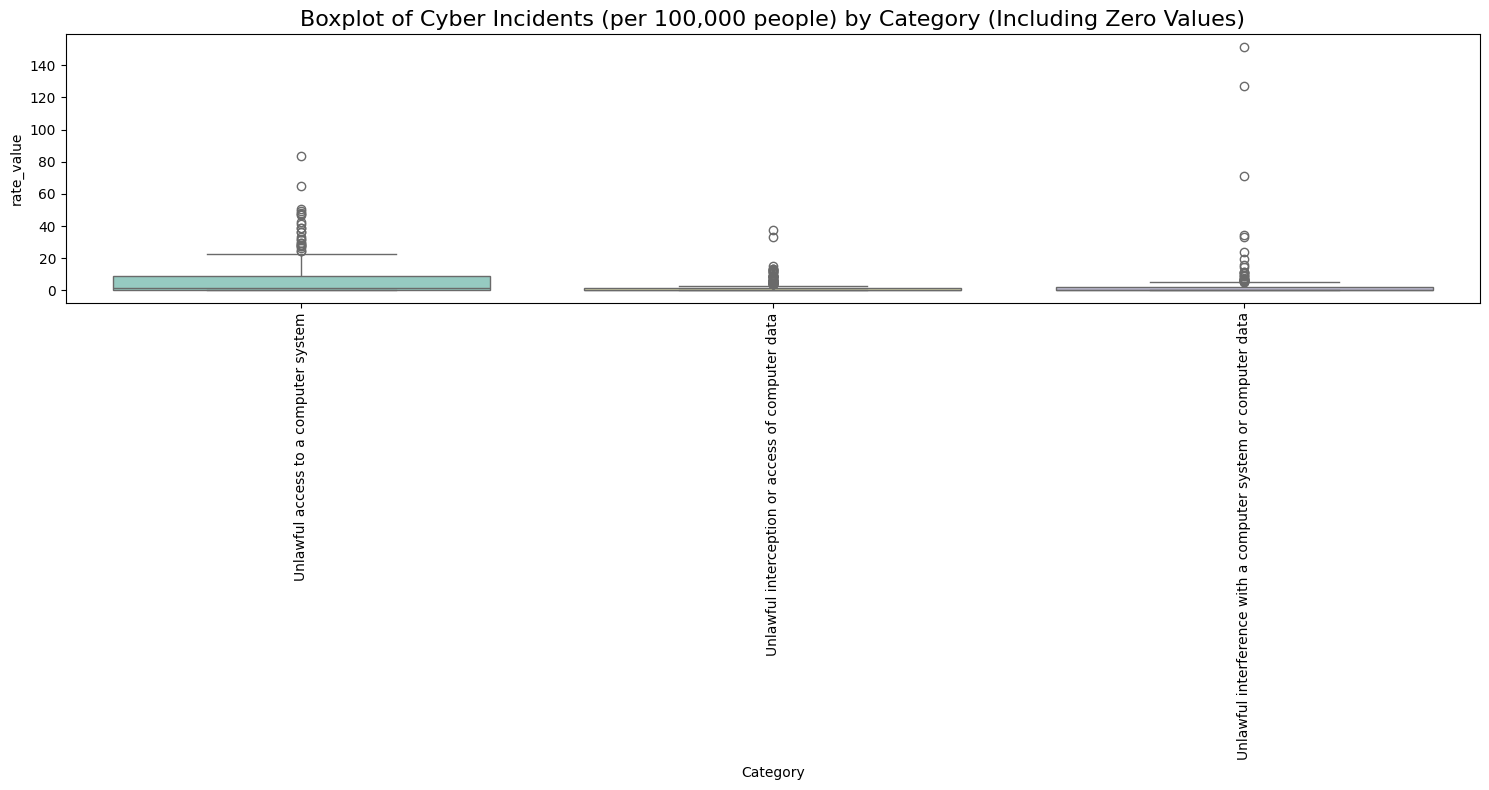

In [ ]:
# Create figure
plt.figure(figsize=(15, 8))

sns.boxplot(data=df_final_cleaned, x='Category', y='rate_value', palette="Set3")

plt.title('Boxplot of Cyber Incidents (per 100,000 people) by Category (Including Zero Values)', fontsize=16)
# Rotate so it is readable
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


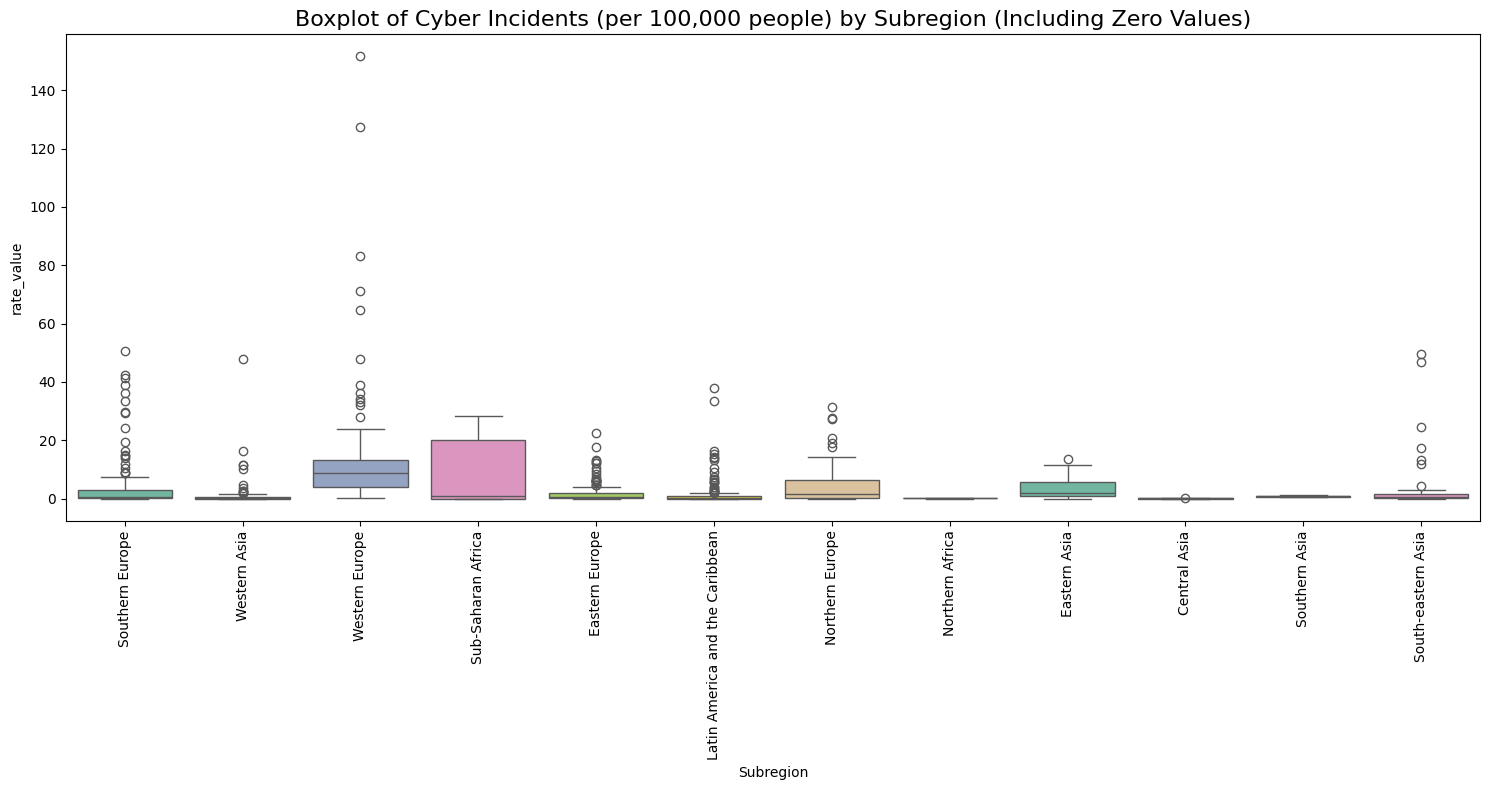

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_final_cleaned, x='Subregion', y='rate_value', hue='Subregion', palette="Set2")

# Set up plot
plt.title('Boxplot of Cyber Incidents (per 100,000 people) by Subregion', fontsize=16)
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


### Geographical data exploration

### Trend analysis over time

#### Change of absolute numbers over time

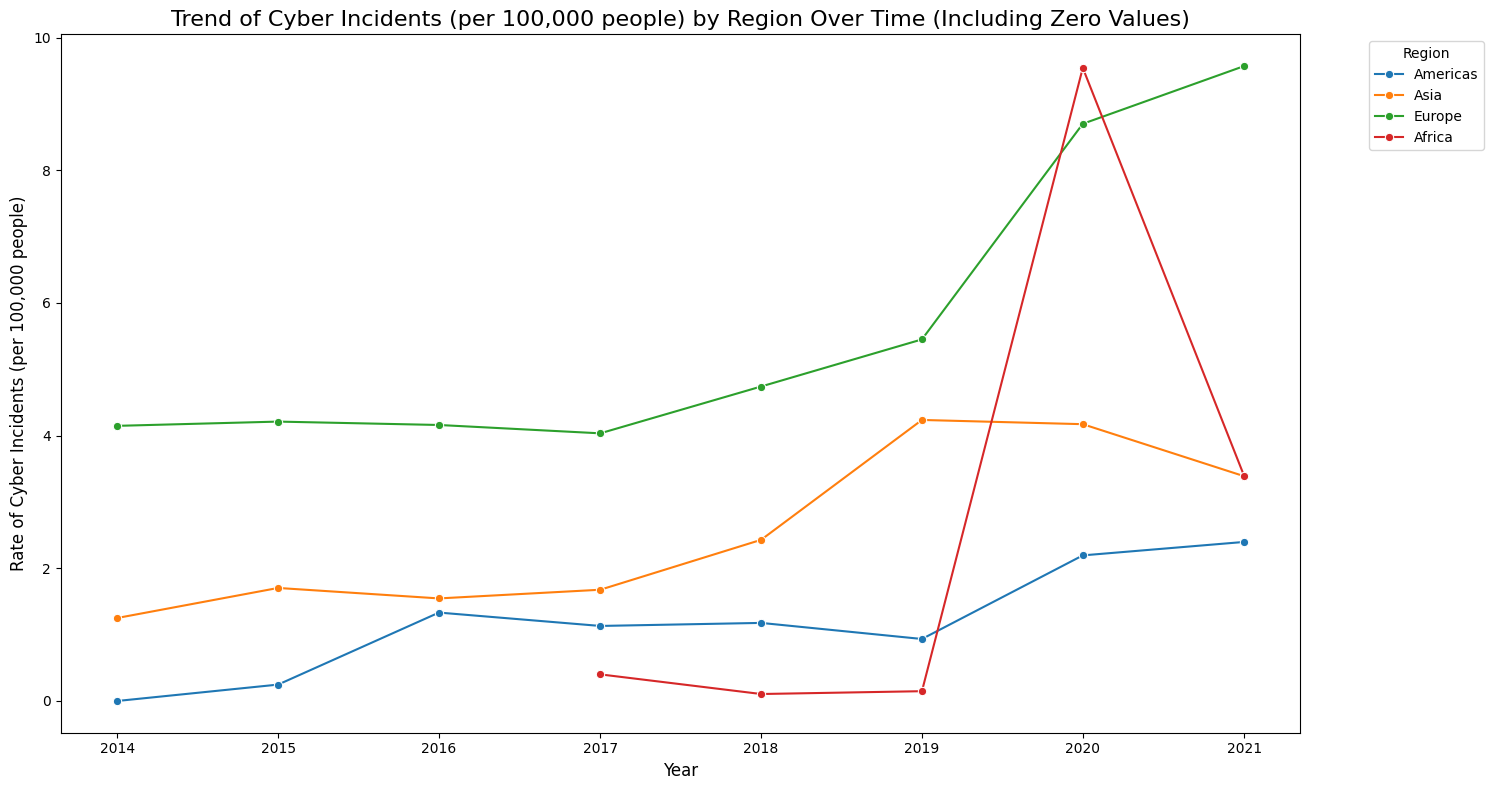

In [ ]:

df_trends = df_final_cleaned.groupby(['Year', 'Region'])['rate_value'].mean().reset_index()


plt.figure(figsize=(15, 8))

sns.lineplot(data=df_trends, x='Year', y='rate_value', hue='Region', marker='o')


plt.title('Trend of Cyber Incidents (per 100,000 people) by Region Over Time (Including Zero Values)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rate of Cyber Incidents (per 100,000 people)', fontsize=12)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


#### Trend analysis by category

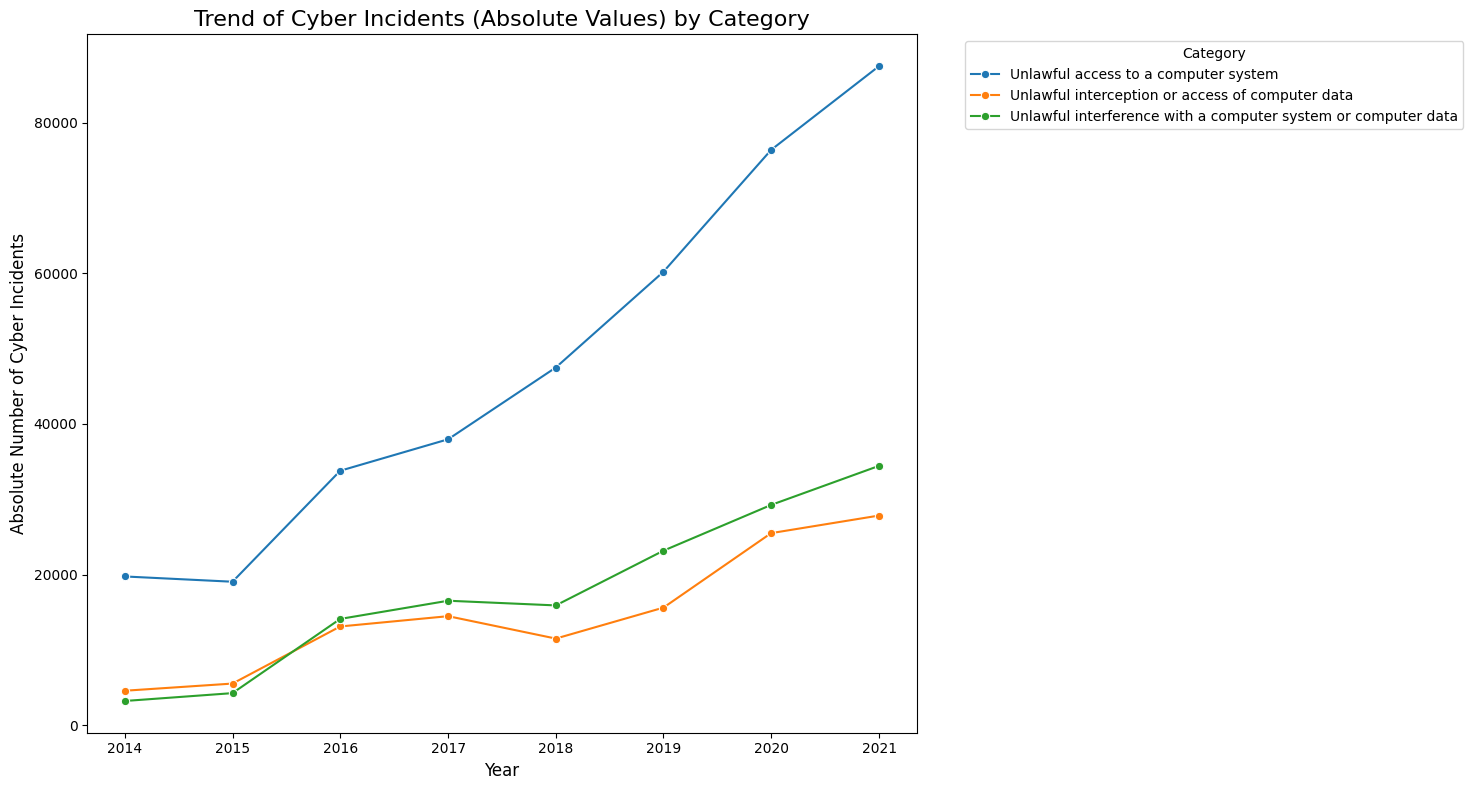

In [ ]:

df_category_trends = df_final_cleaned.groupby(['Year', 'Category'])['absolute_value'].sum().reset_index()


plt.figure(figsize=(15, 8))

sns.lineplot(data=df_category_trends, x='Year', y='absolute_value', hue='Category', marker='o')


plt.title('Trend of Cyber Incidents (Absolute Values) by Category', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Absolute Number of Cyber Incidents', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')



plt.tight_layout()
plt.show()

Unlawful Access to a Computer System:

This category shows a significant increase in the number of incidents over the years, particularly after 2018. This suggests that cybersecurity issues related to unlawful access are becoming more common, possibly due to the increased number of cyberattacks and data breaches.

Unlawful Interception or Access of Computer Data:

This category has a gradual but steady increase in incidents over time. While it doesn't show as sharp a rise as the first category, it still highlights that interception or unauthorized access is a growing concern.

Unlawful Interference with a Computer System or Computer Data:

This category shows a slower but consistent rise, starting around 2017-2018, with a steady increase in incidents. This indicates that cyberattacks targeting systems and data integrity are becoming more frequent, although they are not growing as rapidly as incidents related to access to systems.

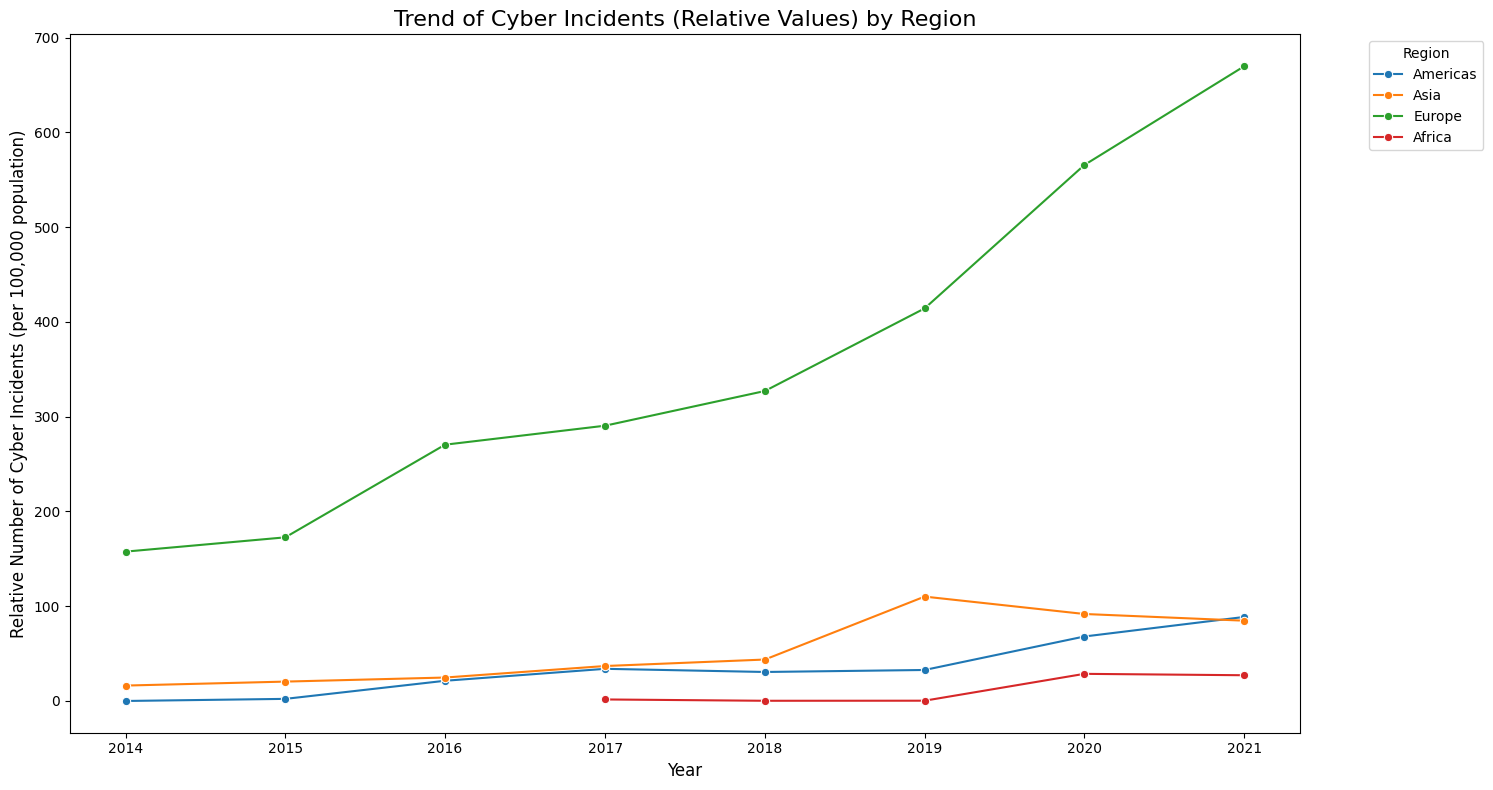

In [ ]:

df_region_trends = df_final_cleaned.groupby(['Year', 'Region'])['rate_value'].sum().reset_index()


plt.figure(figsize=(15, 8))

sns.lineplot(data=df_region_trends, x='Year', y='rate_value', hue='Region', marker='o')


plt.title('Trend of Cyber Incidents (Relative Values) by Region', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Relative Number of Cyber Incidents (per 100,000 population)', fontsize=12)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

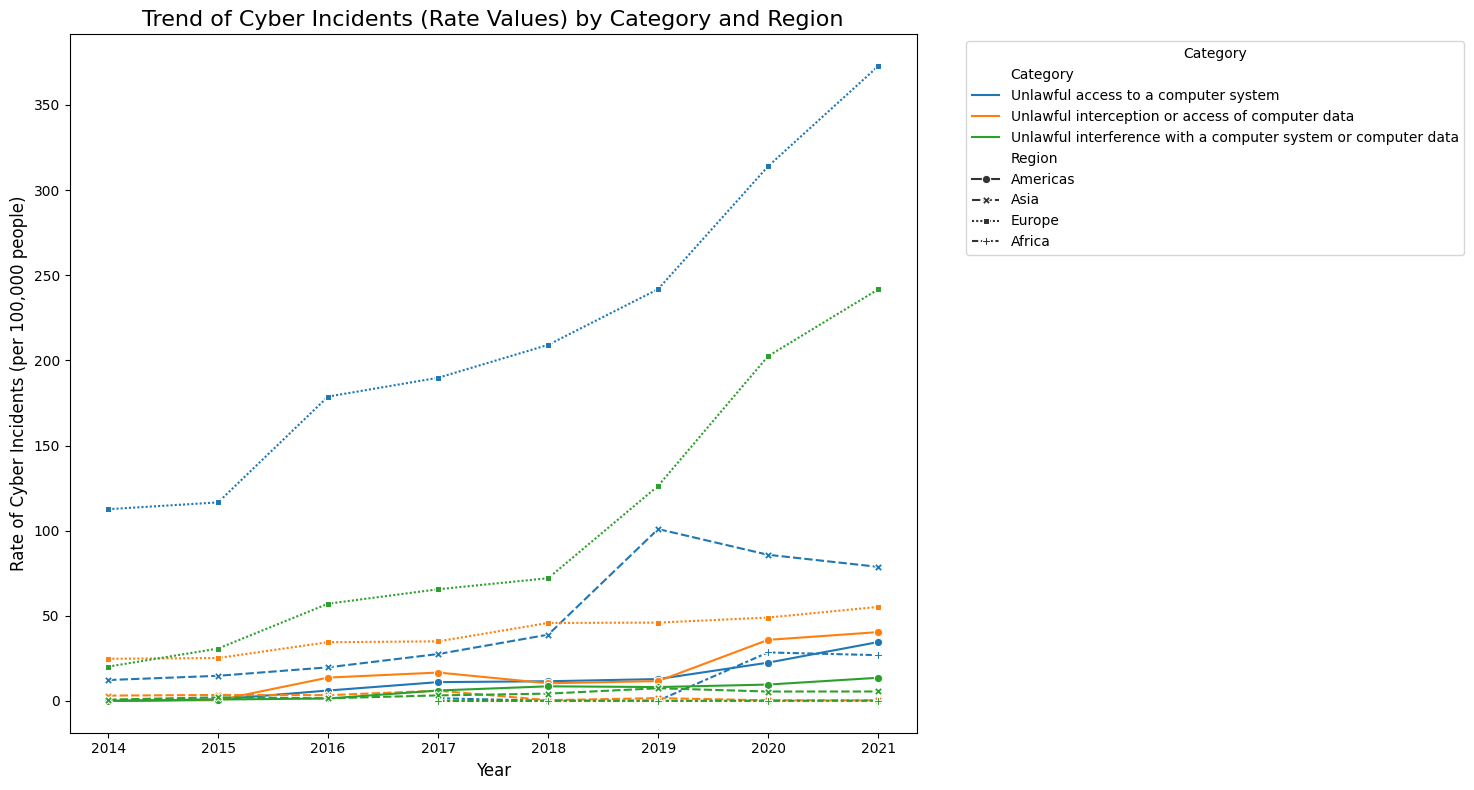

In [ ]:

df_category_trends = df_final_cleaned.groupby(['Year', 'Region', 'Category'])['rate_value'].sum().reset_index()


plt.figure(figsize=(15, 8))

sns.lineplot(data=df_category_trends, x='Year', y='rate_value', hue='Category', style='Region', markers=True)


plt.title('Trend of Cyber Incidents (Rate Values) by Category and Region', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rate of Cyber Incidents (per 100,000 people)', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()


### Outliers

In [ ]:

Q1 = df_final_cleaned['rate_value'].quantile(0.25)
Q3 = df_final_cleaned['rate_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df_final_cleaned[(df_final_cleaned['rate_value'] < lower_bound) | (df_final_cleaned['rate_value'] > upper_bound)]


print("Outliers (Countries with extreme cyber incident rates):")
print(outliers[['Country', 'Region', 'Subregion', 'Year', 'rate_value']])


Outliers (Countries with extreme cyber incident rates):
                     Country  Region           Subregion       Year  \
47                   Austria  Europe      Western Europe 2021-01-01   
54                   Austria  Europe      Western Europe 2016-01-01   
55                   Austria  Europe      Western Europe 2017-01-01   
56                   Austria  Europe      Western Europe 2018-01-01   
57                   Austria  Europe      Western Europe 2019-01-01   
..                       ...     ...                 ...        ...   
771                Singapore    Asia  South-eastern Asia 2018-01-01   
772                Singapore    Asia  South-eastern Asia 2019-01-01   
773                Singapore    Asia  South-eastern Asia 2020-01-01   
774                Singapore    Asia  South-eastern Asia 2021-01-01   
857  Kosovo under UNSCR 1244  Europe     Southern Europe 2016-01-01   

     rate_value  
47    10.670155  
54    10.770920  
55    14.674630  
56    23.776901  
5

#### Deep dive outliers

As we can see above, one of the outliers that got identified is Austria, we will have a closer look and compare the mean value to the one that Austria has.

#### Austria

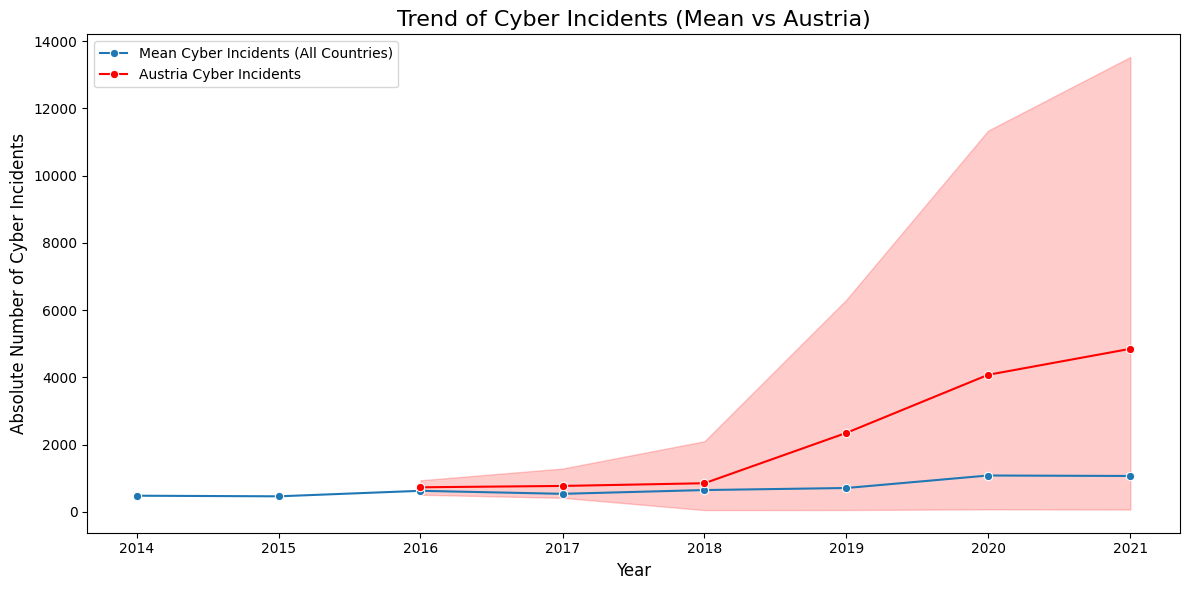

In [ ]:
# Step 1: Group by Year and calculate the mean of absolute_value for all countries
df_mean_per_year = df_final_cleaned.groupby('Year')['absolute_value'].mean().reset_index()

# Step 2: Filter the dataframe to focus on Austria
df_austria = df_final_cleaned[df_final_cleaned['Country'] == 'Austria']

# Step 3: Plot the mean value per year for all countries
plt.figure(figsize=(12, 6))

# Plot the mean value per year
sns.lineplot(data=df_mean_per_year, x='Year', y='absolute_value', marker='o', label='Mean Cyber Incidents (All Countries)')

# Plot Austria's data
sns.lineplot(data=df_austria, x='Year', y='absolute_value', marker='o', label='Austria Cyber Incidents', color='red')

# Step 4: Customize the plot
plt.title('Trend of Cyber Incidents (Mean vs Austria)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Absolute Number of Cyber Incidents', fontsize=12)

# Step 5: Show the plot
plt.tight_layout()
plt.legend()  # Add a legend to differentiate the lines
plt.show()


As we can see above, Austria started recording incidents in 2016 and the absolute number is quite close the mean value of all countries in 2016. But the more recent it gets, the further the lines are apart, showing an stronger increase in cyber incidents in Austria than compared to the rest of the countries in the data set.

### Investigate relationships

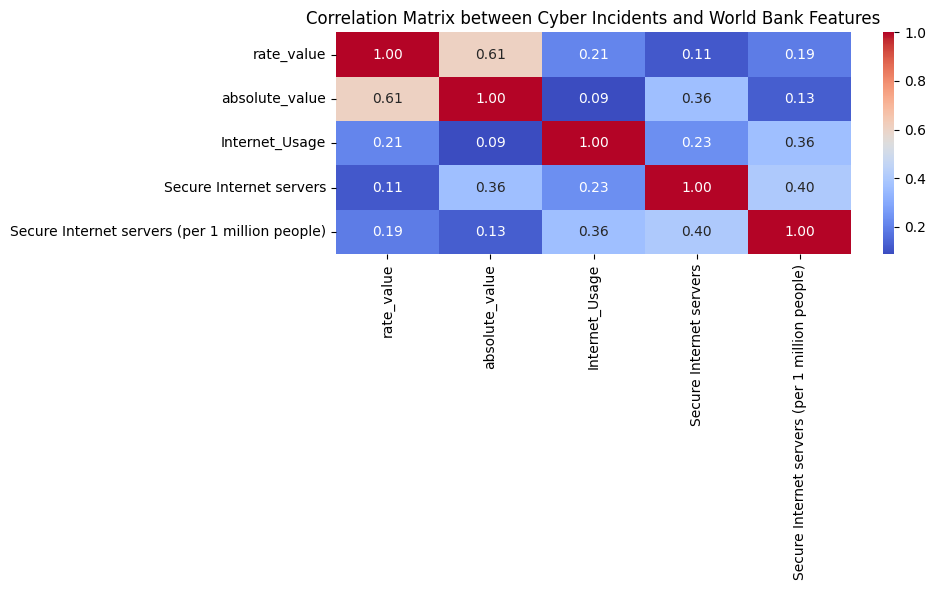

In [ ]:
correlation_columns = [ 'rate_value','absolute_value', 'Internet_Usage', 'Secure Internet servers', 'Secure Internet servers (per 1 million people)']
correlation_matrix = df_final_cleaned[correlation_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Cyber Incidents and World Bank Features")
plt.tight_layout()
plt.show()

####  Investigate Relationships between Cyber Incidents and Other Features

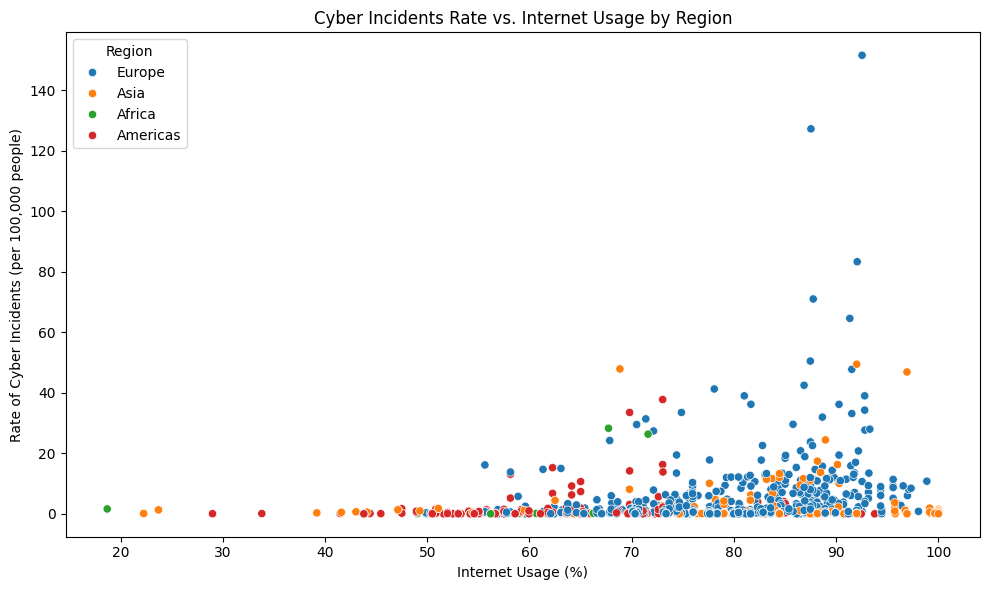

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final_cleaned, x='Internet_Usage', y='rate_value', hue='Region')
plt.title('Cyber Incidents Rate vs. Internet Usage by Region')
plt.xlabel('Internet Usage (%)')
plt.ylabel('Rate of Cyber Incidents (per 100,000 people)')
plt.tight_layout()
plt.show()

### Combination of features

Lastly we don't want to exclusively focus on one feature like category or year, we also want to combine different features and look at them simultaneously.

####  Analyze trends of regions over time

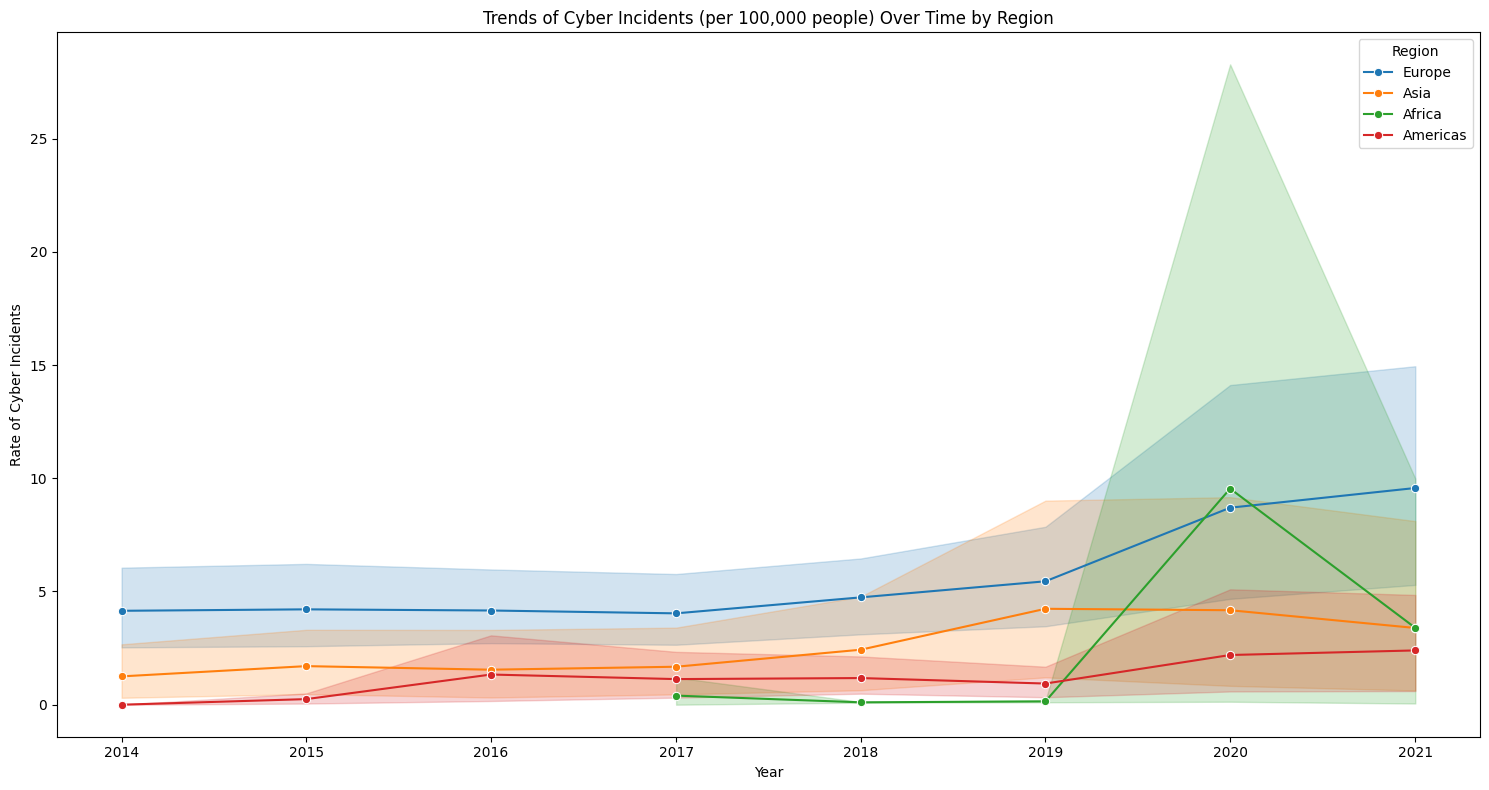

In [ ]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final_cleaned, x='Year', y='rate_value', hue='Region', marker='o')
plt.title('Trends of Cyber Incidents (per 100,000 people) Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Rate of Cyber Incidents')
plt.tight_layout()
plt.show()


#### Explore cateogries of cyber incidents

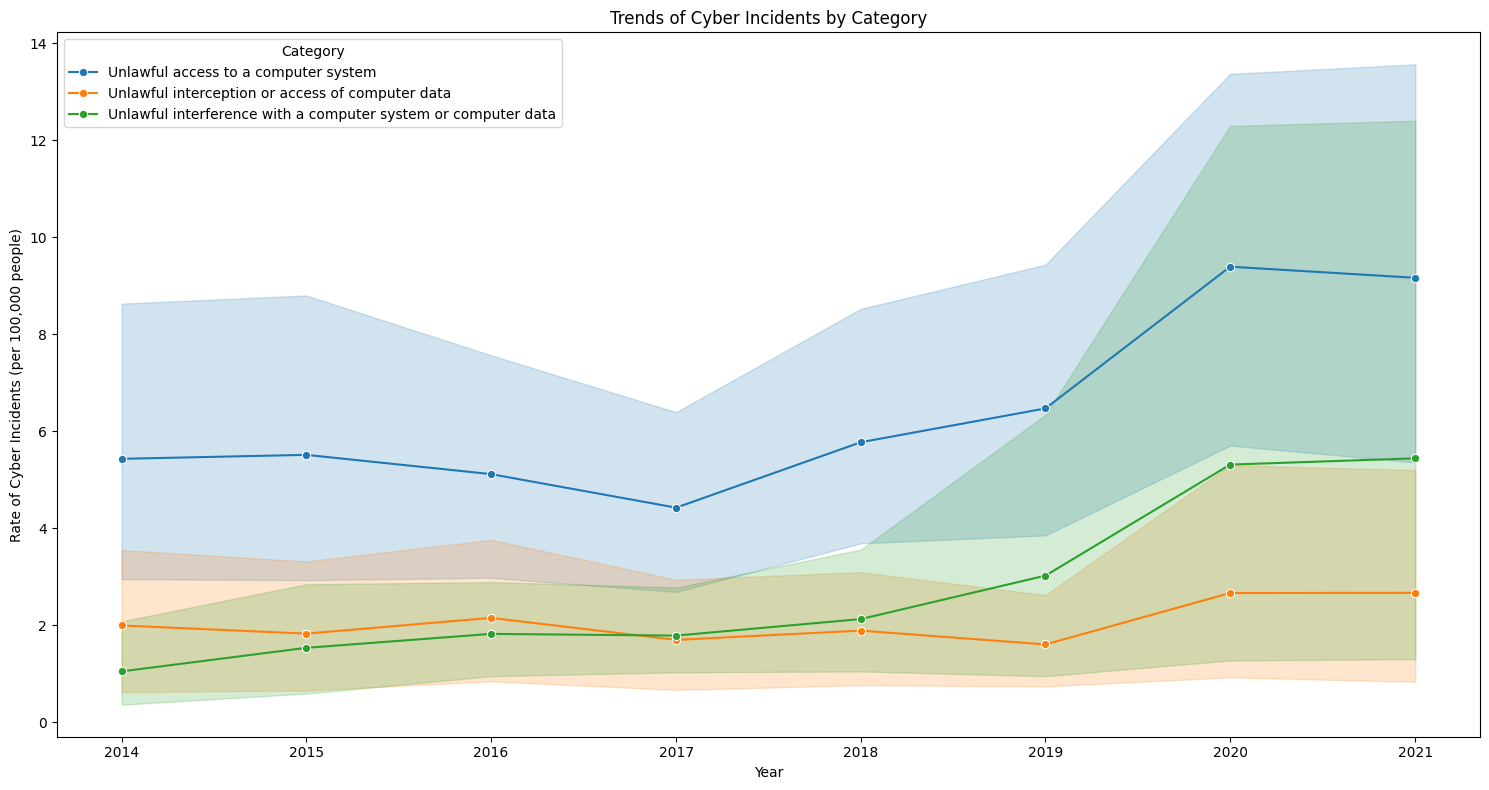

In [ ]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final_cleaned, x='Year', y='rate_value', hue='Category', marker='o')
plt.title('Trends of Cyber Incidents by Category')
plt.xlabel('Year')
plt.ylabel('Rate of Cyber Incidents (per 100,000 people)')
plt.tight_layout()
plt.show()


In [ ]:
fig = px.treemap(df_final_cleaned,
                  path=['Country'],
                  values='rate_value',
                  title="Cyber Incidents per Country (Absolute Values)")


fig.show()

In [ ]:
fig = px.treemap(df_final_cleaned,
                  path=['Country'],
                  values='absolute_value',
                  title="Cyber Incidents per Country (Absolute Values)")


fig.show()

In [ ]:
df_grouped = df_final_cleaned.groupby(['Country', 'Category'])['absolute_value'].sum().reset_index()


fig = px.treemap(df_grouped,
                  path=['Country', 'Category'],
                  values='absolute_value',
                  title="Cyber Incidents (Absolute Values) by Country and Category")


fig.update_traces(
    hovertemplate="<b>%{label}</b><br>Absolute Value: %{value}<br>Category: %{customdata[0]}<br>"
    ,customdata=df_grouped[['Category']].values
)


fig.show()